In [2]:
import torch
from torch.nn import functional as F
from torch import nn
from pytorch_lightning.core.lightning import LightningModule
import pytorch_lightning as pl

import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from src.models import *
from src.dataloader import *
from src.utils import *

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import pickle
import json

import matplotlib.pyplot as plt

In [2]:
ds_train_sr = pickle.load(open('/home/jupyter/data/saved_datasets/testdataset_single_forecast_tp_pure_sr_first_days_5.pkl','rb'))
ds_train = pickle.load(open('/home/jupyter/data/saved_datasets/testdataset_single_forecast_tp_log_trans_first_days_5.pkl', 'rb'))


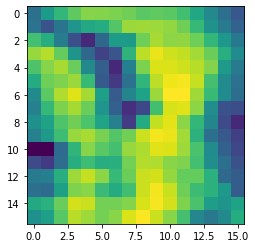

In [13]:
plt.imshow(ds_train[0][0].squeeze())

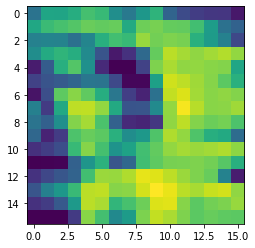

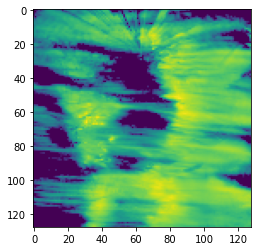

In [11]:
plt.figure()
plt.imshow(ds_train_sr[0][0].squeeze())
plt.figure()
plt.imshow(ds_train_sr[0][1].squeeze())

In [8]:
ds = pickle.load(open('/home/jupyter/data/saved_datasets/testdataset_ensemble_forecast_x10_random_extra_vars_TCW_log_trans_padded_24_first_days_5.pkl', 'rb'))


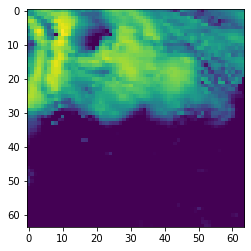

In [16]:
plt.imshow(ds[0][0][0,:,:])
# ds[0][0].shape

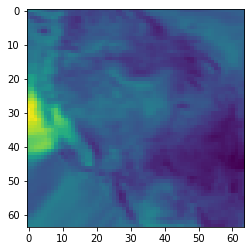

In [17]:
plt.imshow(ds[0][0][1,:,:])

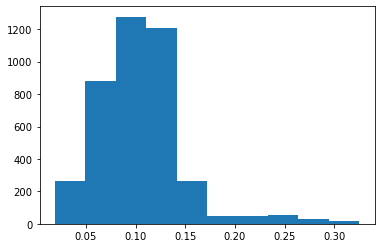

In [22]:
plt.hist(np.reshape(ds[0][0][1,:,:], -1));

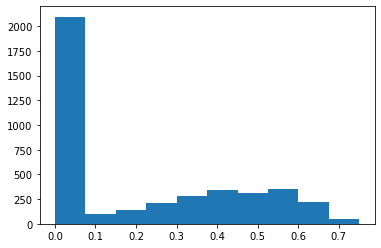

In [23]:
plt.hist(np.reshape(ds[0][0][0,:,:], -1));

In [1]:
import torch
from torch.nn import functional as F
from torch import nn
from pytorch_lightning.core.lightning import LightningModule
import pytorch_lightning as pl

import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from src.models import *
from src.dataloader import *
from src.utils import *

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import pickle
import json

## Train and Val

In [2]:
data_dir = '/home/jupyter/data/'

In [3]:
args = {'tigge_dir':data_dir + f'tigge/32km/',
    'tigge_vars':['total_precipitation', 'total_column_water'],#, '2m_temperature', 'convective_available_potential_energy', 'convective_inhibition'],
    'mrms_dir':data_dir + f'mrms/4km/RadarOnly_QPE_06H/',
    'rq_fn':data_dir + f'mrms/4km/RadarQuality.nc',
#     'const_fn':data_dir + 'tigge/32km/constants.nc',
#     'const_vars':['orog', 'lsm'],
    'data_period':('2018-01', '2018-02'),
    'val_days':5,
    'split':'train',
#     'pure_sr_ratio':8, 
    'tp_log':0.01, 
#     'ensemble_mode':'random',
    'pad_tigge':10, 
     'pad_tigge_channel': True
    }

dataset_name = 'ensemble_forecast_x10_random_log_trans_padded_24'

In [4]:
ds_train = TiggeMRMSDataset(**args)

/opt/conda/envs/ilan/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


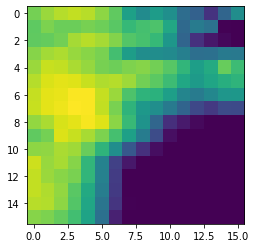

In [5]:
plt.imshow(ds_train[1][0][0])

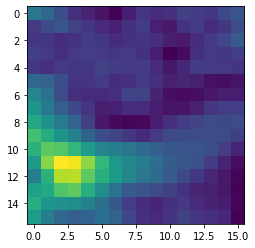

In [6]:
plt.imshow(ds_train[1][0][1])

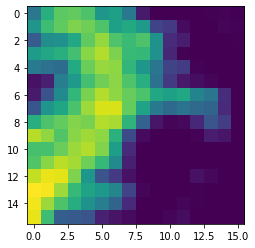

In [7]:
plt.imshow(ds_train[1][0][2])

In [8]:
ds_train[1][0].shape

(3, 16, 16)

In [26]:
time_idx = 9
lat_idx=0
lon_idx =1

lat_slice = slice(lat_idx * 16, (lat_idx+1) * 16 + 10*2)
lon_slice = slice(lon_idx * 16, (lon_idx+1) * 16 + 10*2)
            
X = ds_train.tigge.isel(
            valid_time=time_idx,
            lat=lat_slice,
            lon=lon_slice
        )
X = X.values

DescribeResult(nobs=1296, minmax=(0.0, 0.3872196685336464), mean=0.01302332708065118, variance=0.0020403244794664865, skewness=4.551215856878349, kurtosis=22.832084656526817)
DescribeResult(nobs=1296, minmax=(0.0072600357234478, 0.15032412111759186), mean=0.06632667835327555, variance=0.0007933665565498303, skewness=0.31522096160026286, kurtosis=-0.7402382361029818)
________________
DescribeResult(nobs=1296, minmax=(0.0, 0.41025969542877627), mean=0.02071284046517443, variance=0.0045249064871544465, skewness=3.675962369590254, kurtosis=12.942036937792015)
DescribeResult(nobs=1296, minmax=(0.010127630084753036, 0.18593132495880127), mean=0.06691441287496415, variance=0.0018859004706532512, skewness=0.8001016757681065, kurtosis=-0.5076593151453976)
________________
DescribeResult(nobs=1296, minmax=(0.0, 0.24295261772309396), mean=0.005038937885809055, variance=0.0004416553797990026, skewness=6.750997511485361, kurtosis=53.99154433245168)
DescribeResult(nobs=1296, minmax=(0.00316421454772

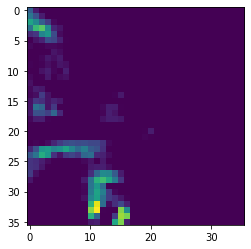

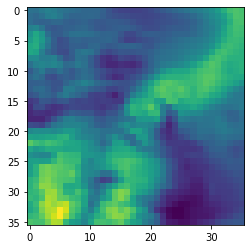

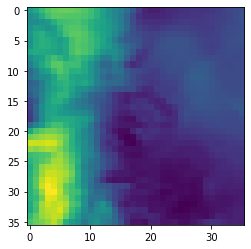

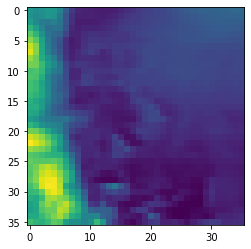

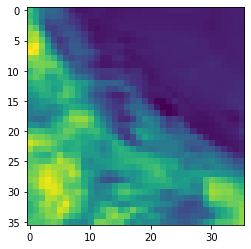

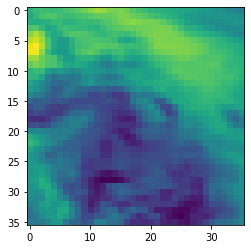

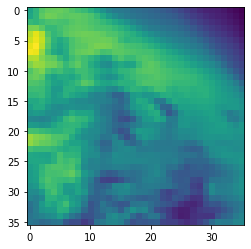

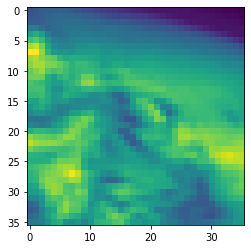

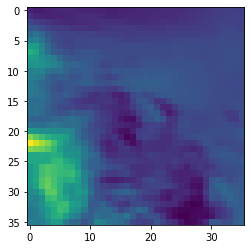

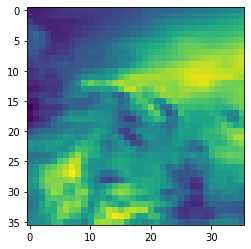

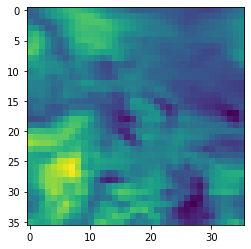

In [44]:
import scipy as sp
idx = 350
time_idx, lat_idx, lon_idx  = ds_train.idxs[idx]

lat_slice = slice(lat_idx * 16, (lat_idx+1) * 16 + 10*2)
lon_slice = slice(lon_idx * 16, (lon_idx+1) * 16 + 10*2)
            
X = ds_train.tigge.isel(
            valid_time=time_idx,
            lat=lat_slice,
            lon=lon_slice
        )
X = X.values

plt.figure()
plt.imshow(X[0])

for i in range(10):
    time_idx, lat_idx, lon_idx  = ds_train.idxs[idx]
    time_idx-=i

    lat_slice = slice(lat_idx * 16, (lat_idx+1) * 16 + 10*2)
    lon_slice = slice(lon_idx * 16, (lon_idx+1) * 16 + 10*2)

    X = ds_train.tigge.isel(
                valid_time=time_idx,
                lat=lat_slice,
                lon=lon_slice
            )
    X = X.values

#     plt.figure()
#     plt.imshow(X[0])
    plt.figure()
    plt.imshow(X[1])
    print(sp.stats.describe(X[0], axis=None))
    print(sp.stats.describe(X[1], axis=None))
    print('________________')



In [19]:
ds_train.idxs[1]

array([0, 0, 1])

In [57]:
sp.stats.describe(ds_train.tigge[0].values, axis = None)

DescribeResult(nobs=1247688, minmax=(0.0, 0.9170368698469178), mean=0.13990598754070277, variance=0.039025520242682445, skewness=1.219238611995331, kurtosis=0.23546853488798236)

In [63]:
def log_trans(x, eps):
    """Log transform with given epsilon. Preserves zeros."""
    return np.log(x + eps) - np.log(eps)

(array([4.28333e+05, 3.35362e+05, 1.59919e+05, 1.24783e+05, 1.04737e+05,
        6.39130e+04, 2.81710e+04, 2.42900e+03, 3.80000e+01, 3.00000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

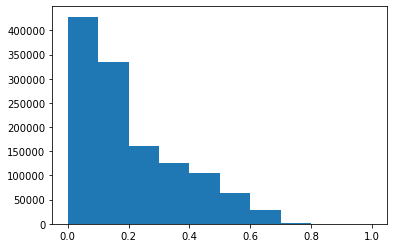

In [68]:
plt.hist(np.reshape(ds_train.tigge[1].values, -1))

(array([7.73242e+05, 8.37070e+04, 8.55880e+04, 8.97400e+04, 8.29120e+04,
        6.50370e+04, 4.36990e+04, 2.01640e+04, 3.51300e+03, 8.60000e+01]),
 array([0.        , 0.09170369, 0.18340737, 0.27511106, 0.36681475,
        0.45851843, 0.55022212, 0.64192581, 0.7336295 , 0.82533318,
        0.91703687]),
 <BarContainer object of 10 artists>)

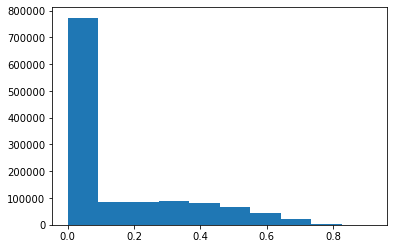

In [62]:
plt.hist(np.reshape(ds_train.tigge[0].values, -1))